# Compare AI requirement classifications: v6 vs v7 (all available years)

Loads all v6/v7 results found under `Results Datasets/ai_mentions/results/requirements/`, shows per-year counts, transition tables (including missing), and lets you list flips with full text/reasons.

In [31]:
from pathlib import Path
import json
import bz2
import pandas as pd

def find_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "Results Datasets").exists():
            return p
    return start

try:
    ROOT = find_root(Path(__file__).resolve())
except NameError:
    ROOT = find_root(Path.cwd())

RES_DIR = ROOT / "Results Datasets" / "ai_mentions" / "results" / "requirements"
TEXT_DIR = ROOT / "Base Dataset" / "Data" / "699_SJMM_Data_TextualData_v10.0" / "sjmm_suf_ad_texts"

def available_years(version: str):
    yrs = []
    for path in RES_DIR.glob(f"ai_job_requirements_all_*_{version}.json"):
        try:
            yrs.append(int(path.name.split('_')[4]))
        except Exception:
            pass
    return sorted(set(yrs))

YEARS = sorted(set(available_years("v7")))#set(available_years("v6")) | 
VERSIONS = ["v6", "v7"]

In [32]:
def load_results(year: int, version: str) -> pd.DataFrame:
    path = RES_DIR / f"ai_job_requirements_all_{year}_{version}.json"
    data = json.loads(path.read_text(encoding="utf-8"))
    rows = []
    for ys, ads in data.items():
        yi = int(ys)
        for ad_id, meta in ads.items():
            rows.append({
                "year": yi,
                "ad_id": ad_id,
                "ai_requirement": meta.get("ai_requirement"),
                "reason": meta.get("reason", ""),
                "keywords": meta.get("keywords", []),
                "version": version,
            })
    return pd.DataFrame(rows)

dfs = []
for y in YEARS:
    for v in VERSIONS:
        path = RES_DIR / f"ai_job_requirements_all_{y}_{v}.json"
        if path.exists():
            dfs.append(load_results(y, v))

results_df = pd.concat(dfs, ignore_index=True)
results_df.head()

,year,ad_id,ai_requirement,reason,keywords,version
0,2014,sjmm_suf-1-01-2014-03-01118-0-000000001,False,No AI/ML terms or AI-adjacent skills mentioned...,[],v6
1,2014,sjmm_suf-1-01-2014-03-01119-0-000000001,False,No AI/ML or AI-adjacent requirements; role foc...,[],v6
2,2014,sjmm_suf-1-01-2014-03-01119-0-000000002,False,No AI/ML mention; role requests CAD and archit...,[],v6
3,2014,sjmm_suf-1-01-2014-03-01119-0-000000003,False,No AI/ML terms; only general IT ('Gute EDV Ken...,[],v6
4,2014,sjmm_suf-1-01-2014-03-01119-0-000000004,False,No AI/ML terms; role is woodworking machine op...,[],v6


<Axes: xlabel='year,version'>

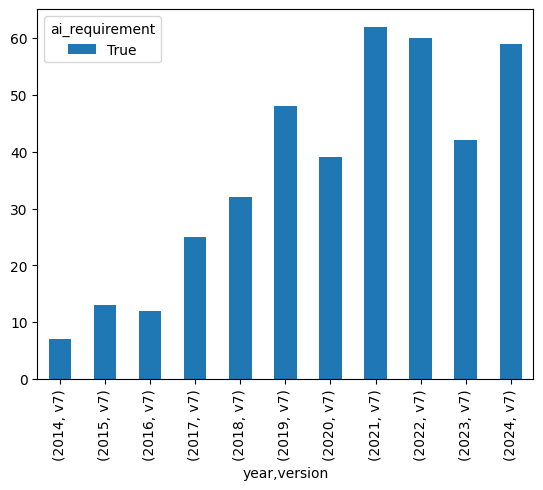

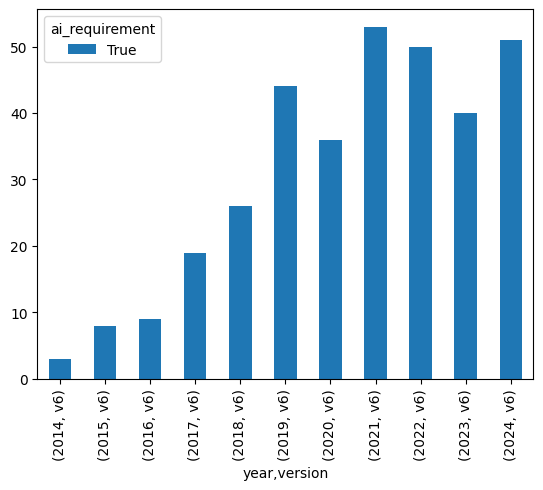

In [44]:
# Counts per year/version/label
counts = results_df.pivot_table(
    index=["year", "version"],
    columns="ai_requirement",
    values="ad_id",
    aggfunc="count",
    fill_value=0,
).sort_index()
counts.query("version == 'v7'").plot(kind = 'bar', y=['True'])
counts.query("version == 'v6'").plot(kind = 'bar', y=['True'])

In [34]:
# Load texts for all available years in this comparison
def load_texts_for_year(year: int) -> dict:
    p = TEXT_DIR / f"ads_sjmm_{year}.jsonl.bz2"
    texts = {}
    if not p.exists():
        return texts
    with bz2.open(p, "rt", encoding="utf-8") as fh:
        for line in fh:
            obj = json.loads(line)
            ad_id = obj.get("adve_iden_adve")
            txt = obj.get("adve_text_adve") or ""
            if ad_id and txt:
                texts[ad_id] = txt
    return texts

text_map = {}
for y in YEARS:
    text_map.update(load_texts_for_year(y))

# Build comparison table (outer merge) with text
v6_df = results_df[results_df["version"] == "v6"][["ad_id", "ai_requirement", "reason", "keywords", "year"]]
v7_df = results_df[results_df["version"] == "v7"][["ad_id", "ai_requirement", "reason", "keywords", "year"]]
comp = v6_df.merge(v7_df, on=["ad_id", "year"], how="outer", suffixes=("_v6", "_v7"))
comp["text"] = comp["ad_id"].map(text_map)
comp.head()

,ad_id,ai_requirement_v6,reason_v6,keywords_v6,year,ai_requirement_v7,reason_v7,keywords_v7,text
0,sjmm_suf-1-01-2014-03-01118-0-000000001,False,No AI/ML terms or AI-adjacent skills mentioned...,[],2014,False,No AI/ML mention; apprenticeship for print tec...,[],Bogenoffsetdrucker oder Bogenoffsetdruckerin D...
1,sjmm_suf-1-01-2014-03-01119-0-000000001,False,No AI/ML or AI-adjacent requirements; role foc...,[],2014,False,No AI/ML terms or AI-adjacent skills; role foc...,[],Küchenchef/in Mensaleitung\n\nKANTON [bild] LU...
2,sjmm_suf-1-01-2014-03-01119-0-000000002,False,No AI/ML mention; role requests CAD and archit...,[],2014,False,No AI/ML terms or AI-adjacent requirements; on...,[],Hochbauzeichner/in\n\n[bild] Tradition. Emotio...
3,sjmm_suf-1-01-2014-03-01119-0-000000003,False,No AI/ML terms; only general IT ('Gute EDV Ken...,[],2014,False,No AI/ML terms or AI-adjacent requirements; on...,[],Bauführer Tiefbau\n\nWir sind eine mittelgross...
4,sjmm_suf-1-01-2014-03-01119-0-000000004,False,No AI/ML terms; role is woodworking machine op...,[],2014,False,No AI/ML or AI-adjacent skills mentioned; role...,[],Schreinermaschinist\n\nWir sind eine erfolgrei...


In [35]:
# Helper to filter by label combos and pretty print
def filter_by_labels(year=None, v6_labels=None, v7_labels=None, limit=None):
    df = comp.copy()
    if year is not None:
        df = df[df["year"].isin(year if isinstance(year, (list, tuple, set)) else [year])]
    if v6_labels is not None:
        df = df[df["ai_requirement_v6"].isin(v6_labels if isinstance(v6_labels, (list, tuple, set)) else [v6_labels])]
    if v7_labels is not None:
        df = df[df["ai_requirement_v7"].isin(v7_labels if isinstance(v7_labels, (list, tuple, set)) else [v7_labels])]
    if limit:
        df = df.head(limit)
    return df

def print_records(df: pd.DataFrame):
    for _, row in df.iterrows():
        print("="*80)
        print(f"Year: {row['year']}  ad_id: {row['ad_id']}")
        print(f"v6: {row['ai_requirement_v6']} | reason: {row['reason_v6']}")
        print(f"v7: {row['ai_requirement_v7']} | reason: {row['reason_v7']}")
        print(f"v6 keywords: {row['keywords_v6']}")
        print(f"v7 keywords: {row['keywords_v7']}")
        print("-- text --")
        print(row.get("text", ""))
        print()

# Transition counts with MISSING included to reconcile totals
comp_pivot = comp.copy()
comp_pivot["ai_requirement_v6"].fillna("MISSING", inplace=True)
comp_pivot["ai_requirement_v7"].fillna("MISSING", inplace=True)

transitions = comp_pivot.pivot_table(
    index="ai_requirement_v6",
    columns="ai_requirement_v7",
    values="ad_id",
    aggfunc="count",
    fill_value=0,
)
print("Overall transitions v6->v7 (MISSING included):")
display(transitions)

print("\nTransitions by year (MISSING included):")
by_year = comp_pivot.pivot_table(
    index=["year", "ai_requirement_v6"],
    columns="ai_requirement_v7",
    values="ad_id",
    aggfunc="count",
    fill_value=0,
).sort_index()
display(by_year)

Overall transitions v6->v7 (MISSING included):


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_51030/2457495939.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  comp_pivot["ai_requirement_v6"].fillna("MISSING", inplace=True)
/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_51030/2457495939.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are se

ai_requirement_v7,False,MISSING,Maybe,True
ai_requirement_v6,,,,
False,38604,52,1350,10
MISSING,3,0,1,0
Maybe,322,0,793,56
True,3,0,3,333



Transitions by year (MISSING included):


ai_requirement_v7       False  MISSING  Maybe  True
year ai_requirement_v6                             
2014 False               3290        0     97     0
     Maybe                 21        0     37     4
     True                   0        0      0     3
2015 False               3199        0    105     0
     Maybe                 21        0     47     5
     True                   0        0      0     8
2016 False               3497        0    110     0
     Maybe                 28        0     66     3
     True                   0        0      0     9
2017 False               3407        0    142     0
     Maybe                 26        0     73     6
     True                   0        0      0    19
2018 False               3548        0    132     1
     Maybe                 31        0     80     7
     True                   1        0      1    24
2019 False               3683        0    146     1
     Maybe                 30        0     83     6
     True                   2        0      1    41
2020 False               3575        0    143     1
     Maybe                 24        0     74     2
     True                   0        0      0    36
2021 False               3632        8    139     1
     Maybe                 41        0     93     8
     True                   0        0      0    53
2022 False               3598       44    153     4
     Maybe                 31        0     80     6
     True                   0        0      0    50
2023 False               3514        0     34     2
     MISSING                2        0      1     0
     Maybe                 35        0     83     1
     True                   0        0      1    39
2024 False               3661        0    149     0
     MISSING                1        0      0     0
     Maybe                 34        0     77     8
     True                   0        0      0    51

In [46]:
# Flips to True in v7 (all years)
flips_to_true = filter_by_labels(year=None, v6_labels=["False", "Maybe"], v7_labels=["True"], limit=None)
print(f"Flips to True (v6=False/Maybe -> v7=True): {len(flips_to_true)}")
print_records(flips_to_true)



Flips to True (v6=False/Maybe -> v7=True): 66
Year: 2014  ad_id: sjmm_suf-2-02-2014-03-00095-0-000002970
v6: Maybe | reason: Mentions 'Bildverarbeitung' and 'Prozessautomation' — could involve computer vision/AI but no explicit ML/AI terms.
v7: True | reason: Mentions 'Bildverarbeitung' (image processing/computer vision) as part of automation components.
v6 keywords: ['Bildverarbeitung', 'Prozessautomation']
v7 keywords: ['Bildverarbeitung']
-- text --
Produkt Manager «Automations-Spezialist» (m/w)

￼ -Freude an Spitzenleistungen
Die Bachofen AG in Uster, mit weiteren Standorten in Biel und Crissier, ist ein seit 1945 be- stehendes, renommiertes Familienunternehmen. Wir bieten unseren Schweizer Kunden aus verschiedensten Branchen Komponenten, Baugruppen, Systeme und Service an. Zur Ver- stärkung des Teams in Biel/Bienne suchen wir eine technisch versierte, selbständige Per- sönlichkeit für die Automation, Division Turck/Banner als
Produkt Manager «Automations-Spezialist» (m/w)
Dank Ihr

In [ ]:
# Flips from True in v7 (all years)
flips_from_true = filter_by_labels(year=None, v6_labels=["True"], v7_labels=["False", "Maybe"], limit=None)

print(f"Flips from True (v6=True -> v7=False/Maybe): {len(flips_from_true)}")
print_records(flips_from_true)

Flips from True (v6=True -> v7=False/Maybe): 6
Year: 2019  ad_id: sjmm_suf-2-02-2019-03-00470-0-000002999
v6: True | reason: Job includes 'Enterprise Applications of Text Analytics' — explicit AI/NLP-related work.
v7: Maybe | reason: Role mentions 'Text Analytics' and IoT/mobile topics that can involve AI but no explicit AI/ML/NLP terms.
v6 keywords: ['Enterprise Applications of Text Analytics']
v7 keywords: ['Smart IoT & Mobile Business', 'Agile Innovation', 'Enterprise Applications of Text Analytics', 'IoT- und Mobile-Business-Anwendungen']
-- text --
wissenschaftliche Mitarbeiterin/Doktorandin oder wissenschaftlichen Mitarbeiter/ Doktoranden (50-70%)

«Ein Ort, der Wissen schafft» - Als eine der führenden Wirtschaftsuniversitäten Europas engagiert sich die Universität St.Gallen (HSG) in der Ausbildung von über 8500 Studierenden und bietet als eine der grössten Arbeitgeberinnen der Region rund 3100 Mitarbeitenden ein attraktives und innovatives Umfeld in Forschung, Lehre, Weiterbildu